### A Song of Vice and Higher: Characterizing Presidential Nominees through Game of Thrones

---

## To Dos
- Fix comment length metric?
- **Explore more gensim features?**
- **Plotting similarity scores**
- **Manually use clusters | similarity scores to match GoT to Dems?**
- plotly express - > 6 colors?


- <s>'Doran'</s> Meh just leave it.
- <s>Should we include `sub_num_comments` and `sub_upvote_ratio` as features</s> Added. Could revert if want to. Might have same issues as comment length.


## Table of Contents

**<a href=#get_data>Get Data</a>**

**<a href=#attribution>Comment Attribution</a>**

**<a href=#person_sentiment>Sentiment by Person</a>**

**<a href=#clusters>Cluster Analysis</a>**

**<a href=#embeddings>Word Embeddings</a>**

**<a href=#clusters2>Cluster Analysis, Revisited</a>**


### Import Necessary Libraries

In [153]:
%matplotlib inline
%load_ext autoreload
%autoreload 1
%aimport helper

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [154]:
%reload_ext autoreload

In [155]:
import os             # file system stuff
import json           # digest json
import pandas as pd   # Dataframes
import numpy as np    # arrays and matrix ops
import string         # string manipulation
import time           # timing

import psycopg2 as psql # PostgreSQL
from itertools import chain # Chain

# Plotting
import matplotlib.pyplot as plt
import plotly_express as px

# Machine Learning
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn import metrics
import gensim         # Word embeddings

# Custom Libs
import helper     # Custom helper functions
from helper import attribute_comment 
from helper import create_person_mat
from helper import add_similarity_score
from helper import person_dict
from helper import domain_dict


In [156]:
print(time.ctime(int(time.time())))

Sun Jun 16 19:34:31 2019


### Connect to the database <a name="get_data"/>

In [157]:
# Define path to secret

# secret_path_aws = os.path.join(os.environ['HOME'], 'mia', '.secret', 
#                            'aws_ps_flatiron.json')
secret_path_aws = os.path.join(os.environ['HOME'], '.secret', 
                           'aws_ps_flatiron.json')
secret_path_aws

'/Users/werlindo/.secret/aws_ps_flatiron.json'

In [158]:
aws_keys = helper.get_keys(secret_path_aws)
user = aws_keys['user']
ps = aws_keys['password']
host = aws_keys['host']
db = aws_keys['db_name']

aws_ps_engine = ('postgresql://' + user + ':' + ps + '@' + host + '/' + db)

# Setup PSQL connection
conn = psql.connect(
    database=db,
    user=user,
    password=ps,
    host=host,
    port='5432'
)

In [159]:
get_database = """
    SELECT * FROM comms_sntmnt_190614;
"""
# Instantiate cursor
cur = conn.cursor()
cur.execute(get_database)
comments = pd.DataFrame(cur.fetchall())
comments.columns = [col.name for col in cur.description]
comments.drop('index', axis=1, inplace=True) #superfluous column
comments.drop(['compound', 'neu'], axis=1, inplace=True) 
#compound and neutral are correlated with other sentiment columns

In [160]:
comments.head()

,domain,comment,sub_num_comments,sub_upvote_ratio,neg,pos
0,dems,"2016, when the dnc pulled the same bullshit th...",710,0.97,0.236,0.069
1,dems,2016: who the hell is beto?\n\n2019: how could...,759,0.96,0.228,0.175
2,dems,>2017 house approval of a $700 billion defense...,105,0.43,0.088,0.383
3,dems,2018,850,0.93,0.000,0.000
4,dems,2018?,508,0.96,0.000,0.000


In [161]:
comments.shape

(324629, 6)

## Attribute Comment to Person <a name='attribution' />

In order to attribute people to `comment`s, we can perform count vectorization. We will need to create a vocabulary.

In [162]:
# Vocabulary will be list of all the search terms we used 
# to pull reddit submissions
vocab = list(chain(*helper.person_dict.values()))

vocab[:10]

['bran',
 'brandon stark',
 'jon',
 'jon snow',
 'khaleesi',
 'dany',
 'daenerys',
 'danyris',
 'danny',
 'danaerys']

Next, set up vectorizer, and then vectorize on this `vocab`

In [163]:
vectorizer = CountVectorizer(vocabulary=vocab)

vectorized_words = vectorizer.transform(comments['comment'])

In [164]:
vectorized_words.shape

(324629, 114)

This gets us an $axn$ matrix, where:
- $a$ is the number of _comments_
- $n$ is the number of _vocab words (search terms)_.

Let's take a look at the vectorized words. Here's one row.

In [165]:
vectorized_words.todense()[5, :]

matrix([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0]])

The columns show the count of vocab word in the comment (row).

In [166]:
# Check
vectorizer.vocabulary[:10]

['bran',
 'brandon stark',
 'jon',
 'jon snow',
 'khaleesi',
 'dany',
 'daenerys',
 'danyris',
 'danny',
 'danaerys']

Now we want to set up a $nxm$ matrix, where:
- $n$ will be number of search terms (e.g. 'dany', daenerys' for **daenerys**) 
- $m$ is the actual number of persons (e.g. **daenerys** herself). 

Let's start with a matrix of `0`s.

In [167]:
person_mat = np.zeros((len(person_dict), len(vocab))).T

person_mat.shape

(114, 67)

Now, let's assign column IDs in the matrix for each _person_.

In [168]:
person_ids = {}

for i, name in enumerate(person_dict.keys()):
    person_ids[name] = i
    
person_ids               

{'bran': 0,
 'jon': 1,
 'dany': 2,
 'davos': 3,
 'doran': 4,
 'cersei': 5,
 'tyrion': 6,
 'sansa': 7,
 'arya': 8,
 'stannis': 9,
 'varys': 10,
 'jamie': 11,
 'brienne': 12,
 'samwell': 13,
 'jorah': 14,
 'theon': 15,
 'hound': 16,
 'littlefinger': 17,
 'joffrey': 18,
 'mountain': 19,
 'robb': 20,
 'dragons': 21,
 'melisandre': 22,
 'bronn': 23,
 'gilly': 24,
 'ramsey': 25,
 'missandei': 26,
 'gendry': 27,
 'grey worm': 28,
 'ned': 29,
 'catelyn': 30,
 'tormund': 31,
 'robert': 32,
 'tommen': 33,
 'viserys': 34,
 'margaery': 35,
 'euron': 36,
 'oberyn': 37,
 'night_king': 38,
 'lyanna': 39,
 'jaqen': 40,
 'hodor': 41,
 'ygritte': 42,
 'mance': 43,
 'harris': 44,
 'biden': 45,
 'buttigieg': 46,
 'gillibrand': 47,
 'hickenlooper': 48,
 'klobuchar': 49,
 'warren': 50,
 'booker': 51,
 'inslee': 52,
 'castro': 53,
 'gabbard': 54,
 'sanders': 55,
 'de blasio': 56,
 'bullock': 57,
 'gravel': 58,
 'messam': 59,
 "o'rourke": 60,
 'bennet': 61,
 'delaney': 62,
 'moulton': 63,
 'swalwell': 64,
 'w

...and assign row ids for each _search term_.

In [169]:
vocab_ids = {}

for i, word in enumerate(vocab):
    vocab_ids[word] = i
    
vocab_ids                

{'bran': 0,
 'brandon stark': 1,
 'jon': 2,
 'jon snow': 3,
 'khaleesi': 4,
 'dany': 5,
 'daenerys': 6,
 'danyris': 7,
 'danny': 8,
 'danaerys': 9,
 'daenarys': 10,
 'davos': 11,
 'doran': 12,
 'cersei': 13,
 'cercei': 14,
 'tyrion': 15,
 'tirion': 16,
 'sansa': 17,
 'arya': 18,
 'stannis': 19,
 'varys': 20,
 'varis': 21,
 'jamie': 22,
 'jaime': 23,
 'brienne': 24,
 'brianne': 25,
 'samwell': 26,
 'jorah': 27,
 'theon': 28,
 'hound': 29,
 'sandor': 30,
 'littlefinger': 31,
 'baelish': 32,
 'joffrey': 33,
 'joff': 34,
 'mountain': 35,
 'gregor': 36,
 'robb': 37,
 'drogo': 38,
 'melisandre': 39,
 'bronn': 40,
 'gilly': 41,
 'ramsey': 42,
 'ramsay': 43,
 'missandei': 44,
 'gendry': 45,
 'grey worm': 46,
 'greyworm': 47,
 'gray worm': 48,
 'grayworm': 49,
 'ned': 50,
 'eddard': 51,
 'catelyn': 52,
 'torumund': 53,
 'tormund': 54,
 'giantsbane': 55,
 'robert': 56,
 'tommen': 57,
 'viserys': 58,
 'margaery': 59,
 'euron': 60,
 'oberon': 61,
 'oberyn': 62,
 'viper': 63,
 'red viper': 64,
 'ni

Now let's use `person_dict` to fill a 1 where each _search term_ matches it's _person_. 

In [170]:
for name, words in person_dict.items():
    person_id = person_ids[name]
    for word in words:
        vocab_id = vocab_ids[word]
        person_mat[vocab_id, person_id] = 1 

In [171]:
person_mat

array([[1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 1.]])

Now we can use matrix multplication to get an $axm$ matrix where:
- $a$: number of _comments_
- $m$: number of _persons_

In [172]:
mentions = vectorized_words @ person_mat 

mentions.shape

(324629, 67)

In [173]:
mentions

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

Get list of _persons_.

In [174]:
persons = list(person_dict.keys())

Create a dataframe from the matrix, with _persons_ as column headers.

In [175]:
mentions_df = pd.DataFrame(mentions, columns=persons, index=comments.index) 

mentions_df.head()

,bran,jon,dany,davos,doran,cersei,tyrion,sansa,arya,stannis,...,bullock,gravel,messam,o'rourke,bennet,delaney,moulton,swalwell,williamson,yang
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Create a `comment_length` feature. We think we will use this as some sort of weighting metric, i.e. the longer the comment, the more weight it carries....?

In [176]:
comments['comment_length'] = comments['comment'].str.len()

comments.head()

,domain,comment,sub_num_comments,sub_upvote_ratio,neg,pos,comment_length
0,dems,"2016, when the dnc pulled the same bullshit th...",710,0.97,0.236,0.069,276
1,dems,2016: who the hell is beto?\n\n2019: how could...,759,0.96,0.228,0.175,80
2,dems,>2017 house approval of a $700 billion defense...,105,0.43,0.088,0.383,170
3,dems,2018,850,0.93,0.000,0.000,4
4,dems,2018?,508,0.96,0.000,0.000,5


The `comment`s have served their purpose, so we can drop them. 

In [177]:
com_use = comments.drop(['comment'],axis=1).copy()

com_use.head()

,domain,sub_num_comments,sub_upvote_ratio,neg,pos,comment_length
0,dems,710,0.97,0.236,0.069,276
1,dems,759,0.96,0.228,0.175,80
2,dems,105,0.43,0.088,0.383,170
3,dems,850,0.93,0.000,0.000,4
4,dems,508,0.96,0.000,0.000,5


Create a master table that has the sentiment analysis **and** the mentions counts.

In [178]:
snm = com_use.join(mentions_df)

snm.head()

,domain,sub_num_comments,sub_upvote_ratio,neg,pos,comment_length,bran,jon,dany,davos,...,bullock,gravel,messam,o'rourke,bennet,delaney,moulton,swalwell,williamson,yang
0,dems,710,0.97,0.236,0.069,276,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,dems,759,0.96,0.228,0.175,80,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0
2,dems,105,0.43,0.088,0.383,170,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,dems,850,0.93,0.000,0.000,4,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,dems,508,0.96,0.000,0.000,5,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


_**Version of table with `comment` column preserved**_


In [179]:
comm_snm = comments.join(mentions_df)

comm_snm.head()

,domain,comment,sub_num_comments,sub_upvote_ratio,neg,pos,comment_length,bran,jon,dany,...,bullock,gravel,messam,o'rourke,bennet,delaney,moulton,swalwell,williamson,yang
0,dems,"2016, when the dnc pulled the same bullshit th...",710,0.97,0.236,0.069,276,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,dems,2016: who the hell is beto?\n\n2019: how could...,759,0.96,0.228,0.175,80,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0
2,dems,>2017 house approval of a $700 billion defense...,105,0.43,0.088,0.383,170,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,dems,2018,850,0.93,0.000,0.000,4,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,dems,2018?,508,0.96,0.000,0.000,5,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


---

### <font color='red'> Digression: Saving out dataframe to-date as a tab-delimited file.

<font color='red'> 2019.06.15 - I commented out these cells; might want to keep them for a couple more days, but don't want to have to keep manually skipping.

**<a href=#bookmark>Click here to skip this section</a>**

#### Write out to tsv

comm_snm.to_csv('comm_snm_190614.tsv', sep='\t')

##### Test reading back in

csnm_test = pd.read_csv('comm_snm_190614.tsv', sep='\t')

csnm_test.info()

csnm_test.head()

csnm_test.shape

comm_snm.shape

We _gained_ a few rows? and a weird index column. Immaterial for now, for think is easily fixable.

Check file size.

file_path_nm = "comm_snm_190614.tsv"
filesize = os.path.getsize(file_path_nm)/1000000

print("file_path_nm is roughly {:,.0f}MB.".format(filesize))

### <font color='red'>End Digression.<a name='bookmark' /></font>

---

## Get aggregate sentiment <a name="person_sentiment" />

We want a table that has `person` on the row, and a column for each `sentiment` metric. We can use matrix multiplication again to achieve that.

In [180]:
mentions.shape

(324629, 67)

In [181]:
# Transpose the mentions matrix
men_t = mentions.T


In [182]:
men_t.shape

(67, 324629)

Isolate just the metrics columns.

In [183]:
# Get the positive sentiment column as an array
features = np.array(snm[['pos','neg','comment_length', 'sub_num_comments', 'sub_upvote_ratio']])

In [184]:
features.shape

(324629, 5)

Compute target matrix of aggregated sentiment.

In [185]:
snm_agg = men_t @ features 

In [186]:
snm_agg.shape

(67, 5)

This gives us a matrix of rows of **persons** by [ **neg**, **pos**, **comment length** ]. But recall this is matrix multiplication, so it gives us the sumproduct. So we need to take the weighted average.

Create an $mx1$ matrix that represents a column of total comment 'hits' for each `person`.

In [187]:
# Get total comments 'hits' by person
men_t_agg = men_t.sum(axis=1)

In [188]:
men_t_agg.shape

(67,)

In [189]:
num_persons = len(persons)

In [190]:
# We need this as an nx1 array
men_t_agg = np.reshape(men_t_agg,(num_persons,1))

In [191]:
men_t_agg.shape

(67, 1)

Now divide the original matrix by 'hits' to get average 'scores'.

In [192]:
snm_avg = np.divide(snm_agg, men_t_agg)

/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning:

invalid value encountered in true_divide



In [193]:
snm_avg[0]

array([9.58706816e-02, 9.64069795e-02, 8.31949230e+02, 6.70082750e+02,
       8.27109691e-01])

This looks right. Now make `persons_df`

In [194]:
persons_df = pd.DataFrame(snm_avg, columns=['neg','pos','comment_length','sub_num_comments', 'sub_upvote_ratio'])

In [195]:
# Add the person's name back in
persons_df['person'] = persons

In [196]:
# Add domain back in
persons_df['domain'] = persons_df['person'].map(domain_dict)

In [197]:
persons_df = persons_df[['person', 'domain', 'neg', 'pos', 'comment_length','sub_num_comments', 'sub_upvote_ratio']]

In [198]:
persons_df.shape

(67, 7)

In [199]:
persons_df.tail(30)

,person,domain,neg,pos,comment_length,sub_num_comments,sub_upvote_ratio
37,oberyn,got,0.118462,0.124522,534.238994,479.792453,0.831691
38,night_king,got,0.096079,0.121316,371.236842,903.605263,0.835658
39,lyanna,got,NaN,NaN,NaN,NaN,NaN
40,jaqen,got,0.081677,0.087890,668.445122,419.310976,0.841022
41,hodor,got,0.058301,0.060560,917.197970,932.293147,0.867453
42,ygritte,got,0.131634,0.102654,500.151220,613.790244,0.846740
43,mance,got,0.095994,0.117767,493.245283,609.440252,0.839277
44,harris,dems,0.121952,0.073905,601.044709,660.970194,0.783690
45,biden,dems,0.112405,0.086870,550.885796,732.629943,0.743179
46,buttigieg,dems,0.121666,0.065769,646.673913,1027.962560,0.838075


In [200]:
persons_df.sort_values(by=['comment_length'], axis=0, ascending=False)

,person,domain,neg,pos,comment_length,sub_num_comments,sub_upvote_ratio
54,gabbard,dems,0.107591,0.092146,1330.751905,688.318571,0.740875
36,euron,got,0.097175,0.139224,958.506540,1093.149752,0.803588
41,hodor,got,0.058301,0.060560,917.197970,932.293147,0.867453
20,robb,got,0.098480,0.131667,902.553476,748.147059,0.825472
12,brienne,got,0.117134,0.113103,898.926866,612.544279,0.801782
26,missandei,got,0.105467,0.144538,891.237405,1195.407177,0.819580
2,dany,got,0.101242,0.136775,887.895739,1012.821503,0.815247
5,cersei,got,0.104796,0.141244,865.036902,931.988191,0.808096
21,dragons,got,0.103937,0.132336,863.264463,929.385675,0.835854
7,sansa,got,0.106343,0.116680,836.954370,752.102963,0.809286


<s>That's it! We will deal with NA's as situations come up.</s>  
Let's get rid of nulls.

In [201]:
persons_df = persons_df.dropna(axis=0)

In [202]:
persons_df.shape

(66, 7)

---

## Cluster Analysis <a name='clusters'/>

### Data Setup

In [203]:
# Create a person-indexed df
persons_cluster = persons_df.set_index(['person']).drop(['domain'], axis=1)

In [204]:
persons_cluster.tail()

,neg,pos,comment_length,sub_num_comments,sub_upvote_ratio
person,,,,,
delaney,0.100648,0.073381,592.190476,556.676190,0.829984
moulton,0.121841,0.063362,419.956522,505.579710,0.740193
swalwell,0.133085,0.066930,554.845070,728.112676,0.814343
williamson,0.085211,0.072123,443.578947,494.824561,0.690614
yang,0.127172,0.059265,641.174575,984.137668,0.839453


In [205]:
persons_cluster.shape

(66, 5)

Drop any nulls.

In [206]:
persons_cluster = persons_cluster.dropna(axis=0)

persons_cluster.shape

(66, 5)

In [207]:
persons_cluster.head()

,neg,pos,comment_length,sub_num_comments,sub_upvote_ratio
person,,,,,
bran,0.095871,0.096407,831.949230,670.082750,0.827110
jon,0.105712,0.123610,797.009912,840.442815,0.824976
dany,0.101242,0.136775,887.895739,1012.821503,0.815247
davos,0.124050,0.092575,692.760499,529.203178,0.834927
doran,0.086200,0.117733,532.200000,453.000000,0.821367


Scale the data.

In [208]:
persons_cluster.dropna(axis=0).shape

(66, 5)

In [209]:
ss = StandardScaler()

ss.fit(persons_cluster)

scaled_X = ss.transform(persons_cluster.dropna(axis=0))

scaled_df = pd.DataFrame(scaled_X, columns=persons_cluster.columns
                         , index=persons_cluster.index)

scaled_df.head()

,neg,pos,comment_length,sub_num_comments,sub_upvote_ratio
person,,,,,
bran,-0.916536,-0.149890,0.948253,-0.173193,0.287603
jon,-0.215131,0.776966,0.746595,0.600592,0.244054
dany,-0.533699,1.225546,1.271157,1.383545,0.045522
davos,1.091774,-0.280437,0.144904,-0.813075,0.447140
doran,-1.605757,0.576743,-0.781796,-1.159194,0.170401


### Find optimal K

**Elbow Method**

In [210]:
# Elbow Method
cluster_variation = []

for k in range(2,16):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(scaled_df)
    cluster_variation.append(kmeans.inertia_)

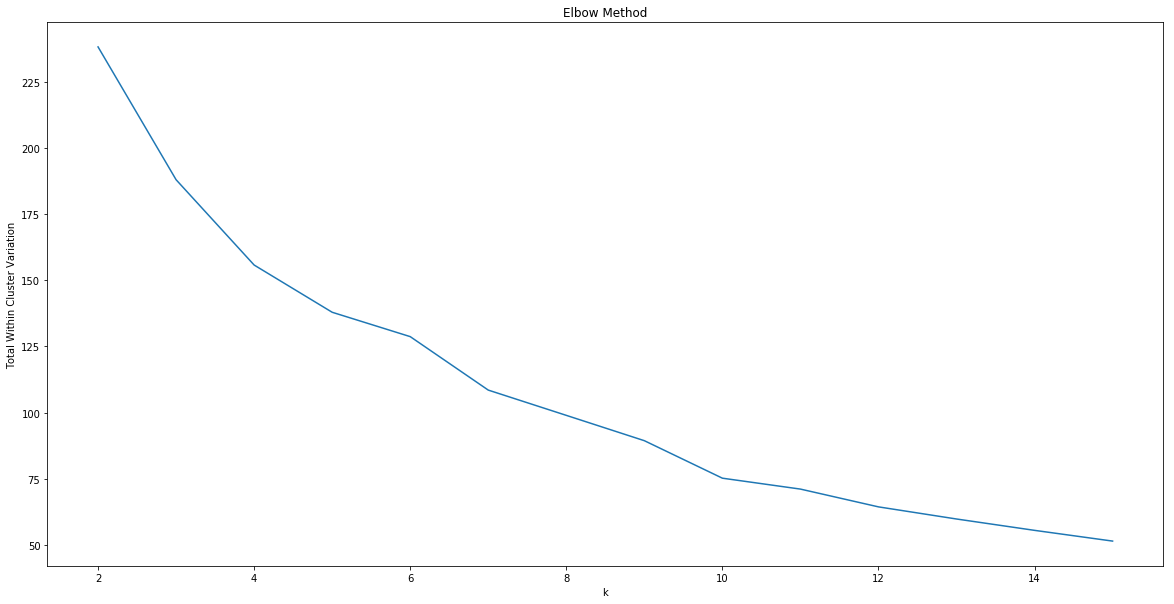

In [211]:
plt.figure(figsize=(20,10))
plt.xlabel('k')
plt.ylabel('Total Within Cluster Variation')
plt.title('Elbow Method')
plt.plot(range(2,16), cluster_variation)


Interesting. Right now we would say k = 4.

### Silhouette Method

In [212]:
silhouette_score = []

for k in range(2,16):
    kmeans = KMeans(n_clusters=k, random_state=42).fit(scaled_df)
    labels = kmeans.labels_
    
    score = metrics.silhouette_score(scaled_df, labels, metric='euclidean')
    silhouette_score.append(score)

In [213]:
#Check 
silhouette_score

[0.28323767017617635,
 0.3000191760396893,
 0.23671211234473763,
 0.23394657119272086,
 0.2365476105885892,
 0.24244119137725903,
 0.2387354478215547,
 0.20787834505987515,
 0.22895145207409853,
 0.21873148593131628,
 0.23960878097817195,
 0.2208507959651452,
 0.2046669573816621,
 0.23771490642677445]

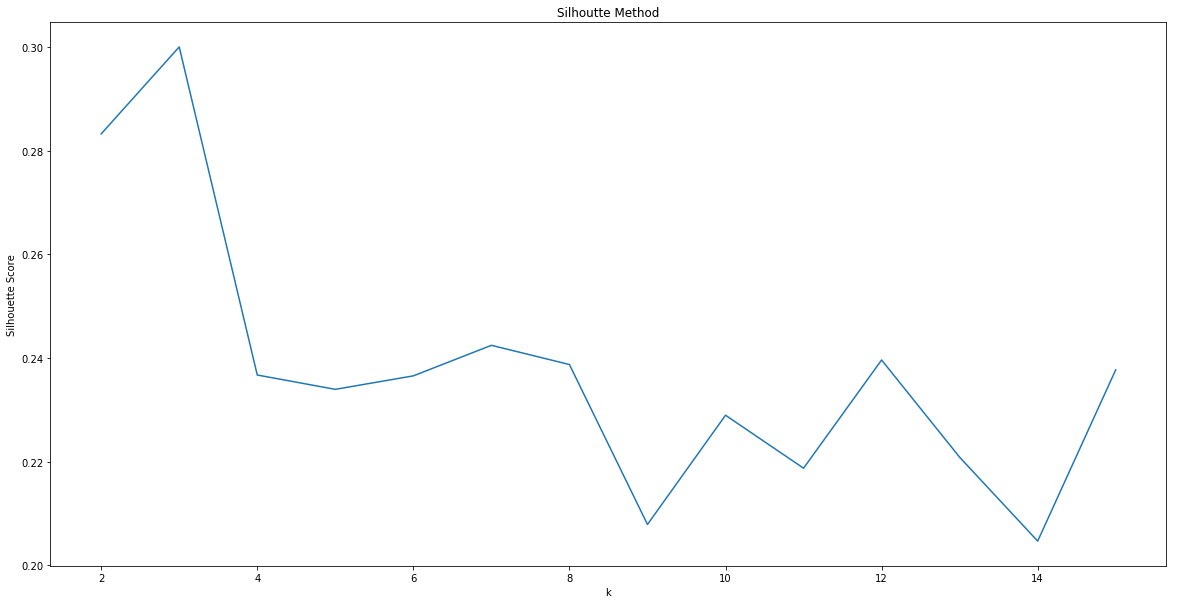

In [214]:
plt.figure(figsize=(20,10))
plt.xlabel('k')
plt.ylabel('Silhouette Score')
plt.title('Silhoutte Method')
plt.plot(range(2,16), silhouette_score)


For silhouette scores, we are looking for the highest score; here it's at where k=3. Let's remember this for later. For now let's do some PCA.

### Principal Components Analysis

This will help us visualize the clusters.

In [215]:
pca = PCA(n_components=2)

pca_data = pca.fit_transform(scaled_df)

pca_df = pd.DataFrame(pca_data, columns=['PCA_1','PCA_2'])
pca_df.shape


(66, 2)

In [216]:
persons_df.dropna(axis=0).shape

(66, 7)

In [217]:
pca_df = persons_df.dropna()[['person','domain']].reset_index().join(pca_df)

In [218]:
pca_df.shape

(66, 5)

In [219]:
persons_cluster.columns

Index(['neg', 'pos', 'comment_length', 'sub_num_comments', 'sub_upvote_ratio'], dtype='object')

In [220]:
pca_df.tail()

,index,person,domain,PCA_1,PCA_2
61,62,delaney,dems,0.814242,0.174856
62,63,moulton,dems,2.643412,0.033101
63,64,swalwell,dems,1.306847,-1.575886
64,65,williamson,dems,2.170170,2.668004
65,66,yang,dems,0.297922,-1.782548


Let's take a quick digression into plotting our data so far.

In [221]:
px.scatter(data_frame=persons_df.dropna()
           ,x='neg'
           ,y='pos'
           ,size='comment_length'
           ,color='domain'
           ,template='ggplot2'
           ,title='Negative vs. Positive Sentiment for Persons'
           ,hover_name='person'
           ,labels={"neg":"Negative Sentiment"
                    ,"pos":"Positive Sentiment"
                    ,"comment_length":"Avg Comment Char Length"
                   }
           ,color_discrete_map={'got':'orange','dems': 'blue'}
          )

Now let's look by PCA.

In [222]:
px.scatter(data_frame=pca_df
           ,x='PCA_1'
           ,y='PCA_2'
           ,color='domain'
           ,template='ggplot2'
           ,title='Principal Components Analysis: Comparison'
           ,hover_name='person'
#            ,labels={"neg":"Negative Sentiment"
#                     ,"pos":"Positive Sentiment"
#                     ,"comment_length":"Avg Comment Char Length"
#                    }
            ,color_discrete_map={'got':'orange','dems': 'blue'}
          )

### K-Means Clustering : k=3

In [223]:
# Model with selected k
k_selected = 3

kmeans = KMeans(n_clusters=k_selected, random_state=42)
kmeans.fit(scaled_df)


KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=3, n_init=10, n_jobs=None, precompute_distances='auto',
    random_state=42, tol=0.0001, verbose=0)

Add clusters to dataframes.

In [224]:
# Add to pre-PCA DF
persons_cluster['cluster'] = kmeans.labels_.astype(str)

In [225]:
# Add to PCA DF
pca_df['cluster'] = kmeans.labels_.astype(str)

Redo charts, except coded by clusters!

In [226]:
px.scatter(data_frame=persons_cluster.reset_index()
           ,x='neg'
           ,y='pos'
           ,size='comment_length'
           ,color='cluster'
           ,template='ggplot2'
           ,title='Negative vs. Positive Sentiment for Persons | By Cluster'
           ,hover_name='person'
           ,labels={"neg":"Negative Sentiment"
                    ,"pos":"Positive Sentiment"
                    ,"comment_length":"Avg Comment Char Length"
                   }
#            ,color_discrete_map={'got':'orange','dems': 'blue'}
          )

In [227]:
px.scatter(data_frame=pca_df
           ,x='PCA_1'
           ,y='PCA_2'
           ,color='cluster'
           ,template='ggplot2'
           ,title='Principal Components Analysis: Comparison, with Similarity Features'
           ,hover_name='person'
#            ,labels={"neg":"Negative Sentiment"
#                     ,"pos":"Positive Sentiment"
#                     ,"comment_length":"Avg Comment Char Length"
#                    }
            ,color_discrete_map={'got':'orange','dems': 'blue'}
          )

Let's look at clusters in order.

In [228]:
persons_cluster.sort_values(by=['cluster'], axis=0)

,neg,pos,comment_length,sub_num_comments,sub_upvote_ratio,cluster
person,,,,,,
yang,0.127172,0.059265,641.174575,984.137668,0.839453,0
tormund,0.126600,0.091105,726.226371,569.534422,0.837853,0
oberyn,0.118462,0.124522,534.238994,479.792453,0.831691,0
ygritte,0.131634,0.102654,500.151220,613.790244,0.846740,0
gilly,0.110157,0.078380,502.444444,684.712963,0.828148,0
harris,0.121952,0.073905,601.044709,660.970194,0.783690,0
biden,0.112405,0.086870,550.885796,732.629943,0.743179,0
buttigieg,0.121666,0.065769,646.673913,1027.962560,0.838075,0
gillibrand,0.107993,0.062662,727.267606,521.179577,0.806185,0


----

# Word Embeddings Analysis <a name='embeddings' />

Let's look at analyzing persons by word embeddings. Perhaps they have interesting relationships within the embedding space!

## Create corpus

In [229]:
# Word2Vec requires that our text have the form of a list
# of 'sentences', where each sentence is itself a list of
# words. How can we put our _Jeopardy!_ clues in that shape?

import string
text = []

for comment in comments['comment']:     
    sentence = comment.translate(str.maketrans('', '', 
                                               string.punctuation)).split(' ')
    
    new_sent = []
    for word in sentence:
        new_sent.append(word.lower().strip().replace('\n',''))
    
    text.append(new_sent)

In [230]:
len(text)

324629

Below, we trained a Word2Vec model, and saved it. We can then just load it back in the future!

In [231]:
# Constructing the model is simply a matter of
# instantiating a Word2Vec object.

# model = gensim.models.Word2Vec(text, sg=1, seed=29)

# To train, call 'train()'!

# model.train(text, total_examples=model.corpus_count, epochs=model.epochs)

# model.save('asovah.model')

In [232]:
model = gensim.models.word2vec.Word2Vec.load('asovah.model')

In [233]:
model.corpus_total_words

13205690

### "Most Similar" Comparisons

In [234]:
# The '.wv' attribute stores the word vectors
model.wv

**A Game of Throne** and **Democratic Presidential candidates** are ostensibly about determining leadership. So let's see if any persons are most similar to the word `leader`?

In [235]:
leader_terms = model.wv.most_similar('leader', topn=10000)

In [236]:
leader_dict = { term[0]: term[1] for term in leader_terms}

In [237]:
len(leader_dict)

10000

In [238]:
leader_dict

{'ruler': 0.6954204440116882,
 'follower': 0.6881744861602783,
 'sullied': 0.6470152139663696,
 'leadership': 0.6271971464157104,
 'uniter': 0.6104315519332886,
 'dictator': 0.6085925698280334,
 'commander': 0.6076716184616089,
 'democratically': 0.6070389151573181,
 'legislator': 0.6056586503982544,
 'speaker': 0.6050797700881958,
 'conqueror': 0.6034949421882629,
 'presidentso': 0.6020423173904419,
 'figurehead': 0.6019771099090576,
 'potus': 0.5895096659660339,
 'guaido': 0.5877032279968262,
 'bullshitter': 0.5863418579101562,
 'president': 0.5861372351646423,
 'invader': 0.5855464935302734,
 'swordsman': 0.5820969343185425,
 'leaders': 0.5816689133644104,
 'policymaker': 0.580181360244751,
 'filibusterproof': 0.5764613151550293,
 'fearless': 0.5750198364257812,
 'unseating': 0.5742335319519043,
 'neighbour': 0.5732023119926453,
 'storyteller': 0.5725693702697754,
 'conquerer': 0.571067750453949,
 'idealist': 0.5691777467727661,
 'bulldozing': 0.5657607316970825,
 'cheerleader': 0.5

**Other investigations**

In [239]:
model.wv.most_similar(['dany'], topn=100)

[('daenerys', 0.9376894235610962),
 ('danny', 0.9288517236709595),
 ('danaerys', 0.8853050470352173),
 ('jon', 0.8342369198799133),
 ('dani', 0.8309235572814941),
 ('she', 0.8113192319869995),
 ('daenarys', 0.7989842295646667),
 ('her', 0.7619372010231018),
 ('sansa', 0.7608339190483093),
 ('cersei', 0.7567245364189148),
 ('danerys', 0.7377527952194214),
 ('tyrion', 0.7342687845230103),
 ('danydany', 0.7274834513664246),
 ('greyworm', 0.7272145748138428),
 ('daeny', 0.7226192951202393),
 ('arya', 0.7225451469421387),
 ('drogon', 0.7221686840057373),
 ('that', 0.7116057872772217),
 ('cercei', 0.7053391337394714),
 ('danys', 0.7052030563354492),
 ('him', 0.6978999376296997),
 ('varys', 0.6966975927352905),
 ('and', 0.695232093334198),
 ('he', 0.6951407194137573),
 ('then', 0.6944849491119385),
 ('backshe', 0.6900995373725891),
 ('herjon', 0.6839209794998169),
 ('everyone', 0.6838222146034241),
 ('jaime', 0.6827793121337891),
 ('thisdany', 0.6804726123809814),
 ('just', 0.6804252862930298

In [240]:
model.wv.most_similar(['deblasio'], topn=100)

[('beefington', 0.6477309465408325),
 ('buttieg', 0.6428749561309814),
 ('berniebut', 0.640867292881012),
 ('gropey', 0.6400903463363647),
 ('warrenpete', 0.6399635076522827),
 ('autistic', 0.6339638829231262),
 ('vpi', 0.6286810040473938),
 ('bidenedit', 0.6282353401184082),
 ('crusty', 0.6269587278366089),
 ('kamala', 0.6267750859260559),
 ('orouke', 0.6264287829399109),
 ('candidatesif', 0.6254308819770813),
 ('gravel', 0.6244787573814392),
 ('butti', 0.6239182949066162),
 ('blasio’s', 0.6180185675621033),
 ('warrenbooker', 0.6173208951950073),
 ('🤦', 0.614010214805603),
 ('fauxcahontas', 0.613972544670105),
 ('lovin', 0.6139574646949768),
 ('blasio', 0.6134762167930603),
 ('swalwell', 0.6123471260070801),
 ('harriswarren', 0.6120682954788208),
 ('pete', 0.6105456352233887),
 ('liz', 0.6089696884155273),
 ('beta', 0.6077377200126648),
 ('bidenalso', 0.6040960550308228),
 ('bullock', 0.6040549874305725),
 ('scarborough', 0.6031465530395508),
 ('buttgeig', 0.6024929285049438),
 ('sup'

Let's start collecting these similarity scores!

Start with making another copy of `persons_df` so we don't accidentally damage it.

In [241]:
persons_embed_df = persons_df.copy()

In [242]:
persons_embed_df.head()

,person,domain,neg,pos,comment_length,sub_num_comments,sub_upvote_ratio
0,bran,got,0.095871,0.096407,831.949230,670.082750,0.827110
1,jon,got,0.105712,0.123610,797.009912,840.442815,0.824976
2,dany,got,0.101242,0.136775,887.895739,1012.821503,0.815247
3,davos,got,0.124050,0.092575,692.760499,529.203178,0.834927
4,doran,got,0.086200,0.117733,532.200000,453.000000,0.821367


Actually, ended up creating a function that add the average similarity score to the person dataframe (where present).

### Using a function to get multiple runs of _most similar_

Do some prep on inputs to function.

In [243]:
# Create a list of terms for which we want to measure similarity.
smlr_tgt_words = ['leader', 'throne', 'presidential']

topn = 10000 # How many top similarity words we want returned

# Create list of target persons (we may need to ignore some persons)
tgt_persons = [person for person in persons_embed_df['person']]

# Create search term list, based on target person
tgt_person_dict = {}
for person in tgt_persons:
    if person in person_dict.keys():
        tgt_person_dict[person] = person_dict[person]
    
# Create list of all search terms
terms = list(chain(*tgt_person_dict.values()))

# Create nxm person matrix, where n=person m=respective search terms
person_mat = create_person_mat(tgt_persons, person_dict)

persons_embed_df = persons_df.copy()

Add features of similarity scores for these selected terms.

In [244]:
for word in smlr_tgt_words:
    add_similarity_score(tgt_word=word
                        ,topn=topn
                        ,w2v_model=model
                        ,tgt_df=persons_embed_df
                        ,term_vocab=terms
                        ,person_mat=person_mat.T
                        )

Completed for :'leader'
Completed for :'throne'
Completed for :'presidential'


In [245]:
persons_embed_df

,person,domain,neg,pos,comment_length,sub_num_comments,sub_upvote_ratio,similarity_leader,similarity_throne,similarity_presidential
0,bran,got,0.095871,0.096407,831.949230,670.082750,0.827110,0.000000,0.480962,0.000000
1,jon,got,0.105712,0.123610,797.009912,840.442815,0.824976,0.390066,0.613652,0.000000
2,dany,got,0.101242,0.136775,887.895739,1012.821503,0.815247,0.342725,0.524774,0.000000
3,davos,got,0.124050,0.092575,692.760499,529.203178,0.834927,0.326616,0.322143,0.000000
4,doran,got,0.086200,0.117733,532.200000,453.000000,0.821367,0.307095,0.417169,0.000000
5,cersei,got,0.104796,0.141244,865.036902,931.988191,0.808096,0.000000,0.471796,0.000000
6,tyrion,got,0.108242,0.118347,803.106100,811.753004,0.830303,0.314670,0.415024,0.000000
7,sansa,got,0.106343,0.116680,836.954370,752.102963,0.809286,0.350210,0.477100,0.000000
8,arya,got,0.098847,0.130279,738.826286,748.072647,0.813146,0.000000,0.416060,0.000000
9,stannis,got,0.108586,0.120870,653.408506,560.555885,0.827574,0.307917,0.432971,0.000000


**Leader** Top 5

In [246]:
col_slice = ['person','similarity_leader']

persons_embed_df.loc[:,col_slice].sort_values(by=col_slice[::-1]
                                                ,ascending=False).head()

,person,similarity_leader
1,jon,0.390066
61,bennet,0.388910
57,bullock,0.385239
51,booker,0.369391
28,grey worm,0.365935


**Throne** Top 5

In [247]:
col_slice = ['person','similarity_throne']

persons_embed_df.loc[:, col_slice].sort_values(by=col_slice[::-1]
                                                ,ascending=False).head()

,person,similarity_throne
1,jon,0.613652
27,gendry,0.575975
2,dany,0.524774
38,night_king,0.519853
0,bran,0.480962


**Presidential** Top 5

In [248]:
col_slice = ['person','similarity_presidential']

persons_embed_df.loc[:, col_slice].sort_values(by=col_slice[::-1]
                                                ,ascending=False).head()

,person,similarity_presidential
57,bullock,0.573037
60,o'rourke,0.557754
52,inslee,0.519273
58,gravel,0.452560
61,bennet,0.449291


¯\_(ツ)_/¯

### Similarity Comparisons

In [249]:
model.wv.similarity('dany', 'warren')

0.40165073

In [250]:
model.wv.similarity('cersei', 'warren')

0.20868585

In [251]:
model.wv.similarity('deblasio', 'warren')

0.560035

### Vector Math

In [252]:
model.wv.most_similar(positive=['sansa', 'north'], negative='throne')

[('aotd', 0.23387563228607178),
 ('foreigners', 0.22676341235637665),
 ('westeros', 0.22251707315444946),
 ('wildlings', 0.22173239290714264),
 ('danger', 0.21841028332710266),
 ('folk', 0.21110036969184875),
 ('helpless', 0.20786961913108826),
 ('marginalized', 0.2058948278427124),
 ('grounded', 0.2051914632320404),
 ('winterfell', 0.20217102766036987)]

In [253]:
model.wv.most_similar(positive=['cersei', 'jamie'], negative='throne')

[('cercei', 0.2643669843673706),
 ('jaime', 0.25998443365097046),
 ('helpless', 0.24754543602466583),
 ('tunnel', 0.23309101164340973),
 ('downtrodden', 0.21889859437942505),
 ('crypt', 0.21493138372898102),
 ('trapped', 0.21474885940551758),
 ('purposefully', 0.21460577845573425),
 ('brienne', 0.21396504342556),
 ('powerless', 0.21385601162910461)]

#### 'doesnt_match()'

In [254]:
model.wv.doesnt_match(['sansa', 'arya', 'jon', 'bran'])

/anaconda3/envs/learn-env/lib/python3.6/site-packages/gensim/models/keyedvectors.py:876: FutureWarning:

arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.



'bran'

In [255]:
model.wv.doesnt_match(['trump', 'warren', 'biden', 'harris'])

/anaconda3/envs/learn-env/lib/python3.6/site-packages/gensim/models/keyedvectors.py:876: FutureWarning:

arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.



'trump'

In [256]:
model.wv.doesnt_match(['warren', 'biden', 'harris'])

/anaconda3/envs/learn-env/lib/python3.6/site-packages/gensim/models/keyedvectors.py:876: FutureWarning:

arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.



'biden'

#### 'closer_than()'

In [257]:
# Which words are closer to 'king' than 'queen' is?

model.wv.closer_than('throne', 'bran')

['he',
 'she',
 'her',
 'him',
 'now',
 'dany',
 'jon',
 'end',
 'cersei',
 'king',
 'power',
 'dragon',
 'north',
 'landing',
 'westeros',
 'daenerys',
 'drogon',
 'rule',
 'claim',
 'iron',
 'herself',
 'snow',
 'kl',
 'nomination',
 'targaryen',
 'kingdoms',
 'jons',
 'ruler',
 'danny',
 'starks',
 'sit',
 'realm',
 'revenge',
 'ruling',
 'wheel',
 'gendry',
 'heir',
 'kingdom',
 'aegon',
 'rightful',
 'crown',
 'hers',
 'targaryens',
 'baratheon',
 'islands',
 'destiny',
 'ashes',
 'danaerys',
 'vengeance',
 'sits',
 'lineage',
 'conquest',
 'targ',
 'succession',
 'birthright',
 'dani',
 'melted',
 'daenarys',
 'lust',
 'heirs',
 'crowned',
 'kingslanding',
 'torched',
 'bloodline',
 'glory',
 'baratheons',
 'usurper',
 'illusion',
 'waits',
 'gendrys',
 'realises',
 'kin',
 'usurped',
 'usurp',
 'reclaim',
 'jonaegon',
 'lordship',
 'joff',
 'nightking',
 'abdicate',
 'unworthy',
 'symbolically',
 'danyjon',
 'jondany',
 'reins',
 'storm’s',
 'kls',
 'danarys',
 'mantle',
 'press

#### 'distance()'

In [258]:
# For this it will make more sense to
# normalize our vectors.

model.init_sims(replace=True)

In [259]:
model.wv.distance('throne', 'jon')

0.3863481283187866

In [260]:
model.wv.distance('throne', 'bran')

0.5190379023551941

In [261]:
model.wv.distance('throne', 'sansa')

0.5228996276855469

In [262]:
model.wv.distance('throne', 'dany')

0.4401234984397888

In [263]:
model.wv.distance('throne', 'tyrion')

0.5727300047874451

### <font color='red'> Note to us: We can probably explore more of these embeddings ideas! </color>

---

## Clusters, revisited <a name='clusters2'/>

In [264]:
persons_embed_df_num = persons_embed_df.drop(['domain'], axis=1).set_index(
                                                                ['person'])

In [265]:
persons_embed_df_num.head()

,neg,pos,comment_length,sub_num_comments,sub_upvote_ratio,similarity_leader,similarity_throne,similarity_presidential
person,,,,,,,,
bran,0.095871,0.096407,831.949230,670.082750,0.827110,0.000000,0.480962,0.0
jon,0.105712,0.123610,797.009912,840.442815,0.824976,0.390066,0.613652,0.0
dany,0.101242,0.136775,887.895739,1012.821503,0.815247,0.342725,0.524774,0.0
davos,0.124050,0.092575,692.760499,529.203178,0.834927,0.326616,0.322143,0.0
doran,0.086200,0.117733,532.200000,453.000000,0.821367,0.307095,0.417169,0.0


In [266]:
ss_2 = StandardScaler()

ss_2.fit(persons_embed_df_num)

scaled_X = ss_2.transform(persons_embed_df_num)

scaled_df_2 = pd.DataFrame(scaled_X
                           ,columns=persons_embed_df_num.columns
                           ,index=persons_embed_df_num.index)

scaled_df_2.head()

,neg,pos,comment_length,sub_num_comments,sub_upvote_ratio,similarity_leader,similarity_throne,similarity_presidential
person,,,,,,,,
bran,-0.916536,-0.149890,0.948253,-0.173193,0.287603,-0.934358,1.226858,-0.71459
jon,-0.215131,0.776966,0.746595,0.600592,0.244054,1.372459,1.901173,-0.71459
dany,-0.533699,1.225546,1.271157,1.383545,0.045522,1.092487,1.449508,-0.71459
davos,1.091774,-0.280437,0.144904,-0.813075,0.447140,0.997223,0.419758,-0.71459
doran,-1.605757,0.576743,-0.781796,-1.159194,0.170401,0.881774,0.902667,-0.71459


### Find optimal K

**Elbow Method**

In [267]:
# Elbow Method
cluster_variation = []

for k in range(2,16):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(scaled_df_2)
    cluster_variation.append(kmeans.inertia_)

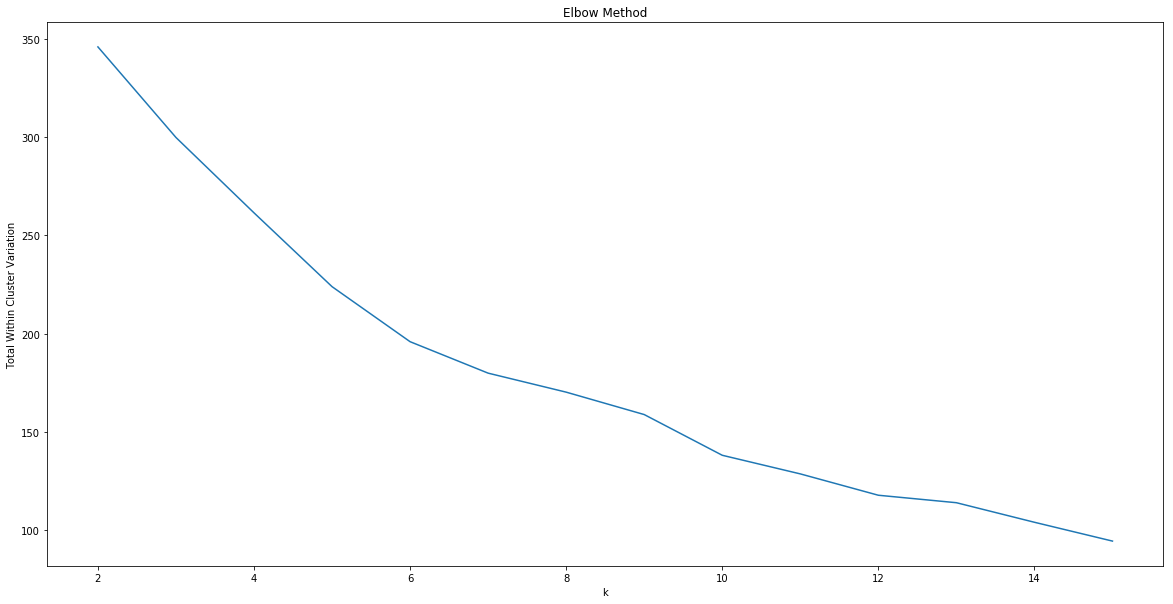

In [268]:
plt.figure(figsize=(20,10))
plt.xlabel('k')
plt.ylabel('Total Within Cluster Variation')
plt.title('Elbow Method')
plt.plot(range(2,16), cluster_variation)


Interesting. Pretty subtle, but maybe 6 or 10?

### Silhouette Method

In [269]:
silhouette_score = []

for k in range(2,16):
    kmeans = KMeans(n_clusters=k, random_state=42).fit(scaled_df_2)
    labels = kmeans.labels_
    
    score = metrics.silhouette_score(scaled_df, labels, metric='euclidean')
    silhouette_score.append(score)

In [270]:
#Check 
silhouette_score

[0.25683689760896766,
 0.2528569306368524,
 0.12238392140417975,
 0.0462371728775348,
 0.05937244349602166,
 0.052373104045588974,
 0.03575463260617141,
 0.05481490061573689,
 0.003803063067901794,
 0.05333875323993728,
 -0.003939775510465747,
 -0.005302354757305436,
 0.021210619656760635,
 0.011221407803255172]

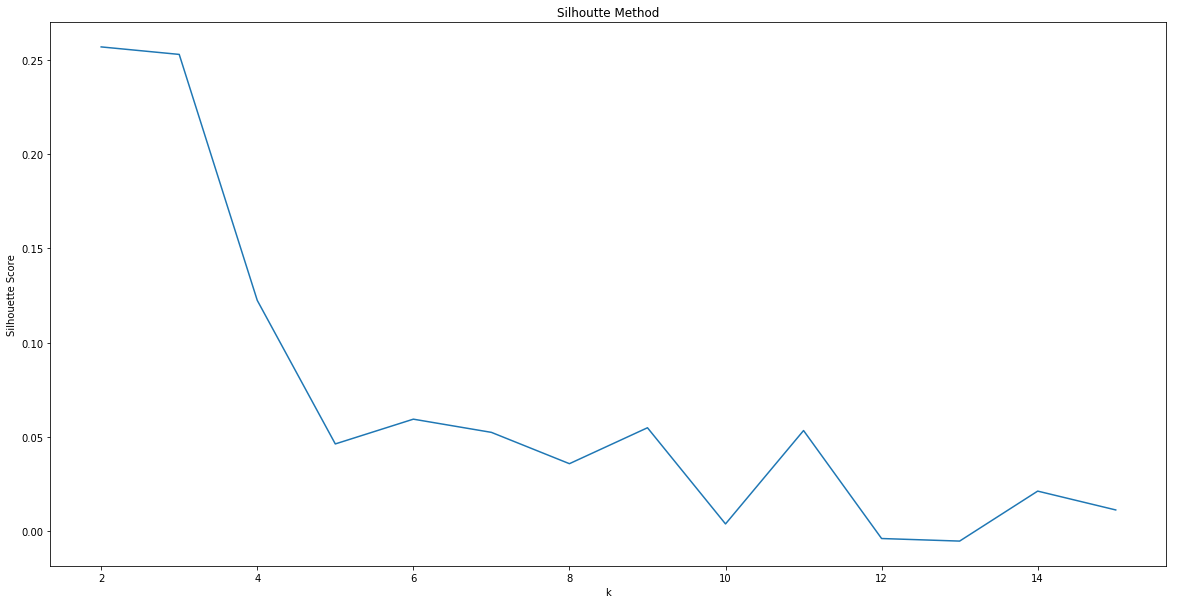

In [271]:
plt.figure(figsize=(20,10))
plt.xlabel('k')
plt.ylabel('Silhouette Score')
plt.title('Silhoutte Method')
plt.plot(range(2,16), silhouette_score)


Suggests 2 is the best k!

Between the two, 6 would be more interesting to explore.

### Principal Components Analysis - Round 2

This will help us visualize the clusters.

In [272]:
pca = PCA(n_components=2)

pca_data = pca.fit_transform(scaled_df_2)

pca_df = pd.DataFrame(pca_data, columns=['PCA_1','PCA_2'])
pca_df.shape


(66, 2)

persons_df.dropna(axis=0).shape

In [273]:
pca_df = persons_df.dropna()[['person','domain']].reset_index().join(pca_df)

In [274]:
pca_df.shape

(66, 5)

In [275]:
pca_df.tail()

,index,person,domain,PCA_1,PCA_2
61,62,delaney,dems,0.495172,0.642853
62,63,moulton,dems,3.319720,-0.181480
63,64,swalwell,dems,1.761400,-1.815353
64,65,williamson,dems,2.821969,2.071879
65,66,yang,dems,1.408044,-0.411109


Now let's look by PCA again, **after adding in new similarity features**.

In [276]:
px.scatter(data_frame=pca_df
           ,x='PCA_1'
           ,y='PCA_2'
           ,color='domain'
           ,template='ggplot2'
           ,title='Principal Components Analysis: Comparison, with Similiarity Features'
           ,hover_name='person'
#            ,labels={"neg":"Negative Sentiment"
#                     ,"pos":"Positive Sentiment"
#                     ,"comment_length":"Avg Comment Char Length"
#                    }
            ,color_discrete_map={'got':'orange','dems': 'blue'}
          )

Looks like it really sharpened the distincting between the two PCA groupings; you can (almost) draw a straight line between the two PCA groups, whereas before there was some minor overlap.

### K-Means Clustering - k=6

In [277]:
#### Model with selected k
k_selected = 6

kmeans = KMeans(n_clusters=k_selected, random_state=42)
kmeans.fit(scaled_df_2)


KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=6, n_init=10, n_jobs=None, precompute_distances='auto',
    random_state=42, tol=0.0001, verbose=0)

Add clusters to dataframes.

In [278]:
# Add to pre-PCA DF
persons_cluster['cluster'] = kmeans.labels_.astype(str)

In [279]:
# Add to PCA DF
pca_df['cluster'] = kmeans.labels_.astype(str)

Redo charts, except coded by clusters!

In [280]:
px.scatter(data_frame=persons_cluster.reset_index()
           ,x='neg'
           ,y='pos'
           ,size='comment_length'
           ,color='cluster'
           ,template='ggplot2'
           ,title='Negative vs. Positive Sentiment for Persons | By Cluster'
           ,hover_name='person'
           ,labels={"neg":"Negative Sentiment"
                    ,"pos":"Positive Sentiment"
                    ,"comment_length":"Avg Comment Char Length"
                   }
#            ,color_discrete_map={'got':'orange','dems': 'blue'}
          )

Kind of compelling. There is some bleed.

In [281]:
px.scatter(data_frame=pca_df
           ,x='PCA_1'
           ,y='PCA_2'
           ,color='cluster'
           ,template='ggplot2'
           ,title='Principal Components Analysis: Comparison'
           ,hover_name='person'
#            ,labels={"neg":"Negative Sentiment"
#                     ,"pos":"Positive Sentiment"
#                     ,"comment_length":"Avg Comment Char Length"
#                    }
            ,color_discrete_map={'got':'orange','dems': 'blue'}
          )

This is more compelling than just looking at positive vs negative; makes sense because the PCAs have reduced the dimensions down.

Let's look at clusters in order.

In [282]:
persons_cluster.sort_values(by=['cluster'], axis=0)

,neg,pos,comment_length,sub_num_comments,sub_upvote_ratio,cluster
person,,,,,,
mance,0.095994,0.117767,493.245283,609.440252,0.839277,0
night_king,0.096079,0.121316,371.236842,903.605263,0.835658,0
joffrey,0.109822,0.140544,520.881590,909.345499,0.861702,0
littlefinger,0.109987,0.113178,765.276119,667.201493,0.822792,0
grey worm,0.096666,0.149123,717.217759,805.680761,0.806900,0
varys,0.101486,0.127533,800.279455,1004.412374,0.830412,0
stannis,0.108586,0.120870,653.408506,560.555885,0.827574,0
gendry,0.098096,0.091402,643.932039,598.542718,0.822549,0
davos,0.124050,0.092575,692.760499,529.203178,0.834927,0


In [283]:
print(time.ctime(int(time.time())))

Sun Jun 16 19:35:31 2019


-----

# <font color='steelblue'>Dev and Testing </font>
###  <font color='steelblue'>Delete these eventually </font>

In [ ]:
arr = vectorized_similars.todense()

row_ind_nz = (arr!=0).argmax(axis=0)

In [ ]:
row_ind_nz

So first non-zero row in column 1 is 1701.

In [ ]:
arr[1701,0]

This means that index 1701 of `leader_terms` should give us a character match! 

In [ ]:
leader_terms[1701]

Yes. Seems to work! Let's check another. how about 4073?

In [ ]:
leader_terms[4073]

Let's codify the number $n$ of how many similar words to return from the the `most_similar` method.

In [ ]:
num_similar_words = 10000

Now, let's count vectorize the terms. We'll use the same search term vocabulary as before!

In [ ]:
embed_vectorizer = CountVectorizer(vocabulary=vocab)

In [ ]:
vectorized_similars = embed_vectorizer.transform(
                                    [term[0] for term in leader_terms])

In [ ]:
vectorized_similars.shape

In [ ]:
# Let's spot check. Let's find a non-zero cell.

In [ ]:
arr = vectorized_similars.todense()

row_ind_nz = (arr!=0).argmax(axis=0)

In [ ]:
row_ind_nz

So first non-zero row in column 1 is 1701.

In [ ]:
arr[1701,0]

This means that index 1701 of `leader_terms` should give us a character match! 

In [ ]:
leader_terms[1701]

Yes. Seems to work! Let's check another. how about 4073?

In [ ]:
leader_terms[4073]

Let's codify the number $n$ of how many similar words to return from the the `most_similar` method.

In [ ]:
num_similar_words = 10000

Now, let's count vectorize the terms. We'll use the same search term vocabulary as before!

In [ ]:
embed_vectorizer = CountVectorizer(vocabulary=vocab)

In [ ]:
vectorized_similars = embed_vectorizer.transform(
                                    [term[0] for term in leader_terms])

In [ ]:
vectorized_similars.shape

In [ ]:
# Let's spot check. Let's find a non-zero cell.

In [ ]:
arr = vectorized_similars.todense()

row_ind_nz = (arr!=0).argmax(axis=0)

In [ ]:
row_ind_nz

So first non-zero row in column 1 is 1701.

In [ ]:
arr[1701,0]

This means that index 1701 of `leader_terms` should give us a character match! 

In [ ]:
leader_terms[1701]

Yes. Seems to work! Let's check another. how about 4073?

In [ ]:
leader_terms[4073]

Let's codify the number $n$ of how many similar words to return from the the `most_similar` method.

In [ ]:
num_similar_words = 10000

Now, let's count vectorize the terms. We'll use the same search term vocabulary as before!

In [ ]:
embed_vectorizer = CountVectorizer(vocabulary=vocab)

In [ ]:
vectorized_similars = embed_vectorizer.transform(
                                    [term[0] for term in leader_terms])

In [ ]:
vectorized_similars.shape

In [ ]:
# Let's spot check. Let's find a non-zero cell.

In [ ]:
arr = vectorized_similars.todense()

row_ind_nz = (arr!=0).argmax(axis=0)

In [ ]:
row_ind_nz

So first non-zero row in column 1 is 1701.

In [ ]:
arr[1701,0]

This means that index 1701 of `leader_terms` should give us a character match! 

In [ ]:
leader_terms[1701]

Yes. Seems to work! Let's check another. how about 4073?

In [ ]:
leader_terms[4073]

In [ ]:
# Get leader words
similar_words = [key_val for key_val in leader_dict]

In [ ]:
# Create zeroes matrix
scores_mat = np.zeros((num_similar_words, len(vocab)))

scores_mat.shape

# Loop throught the vocab
for i, search_term in enumerate(vocab):
    col = i
    # If person in similar words list, retrieve the score
    if search_term in similar_words:
#         print(search_term)
        row = similar_words.index(search_term) 
        score = leader_dict[search_term]
        print(row, col, score)
        scores_mat[row, col] = score


Check values.

In [ ]:
# Check
print(vectorized_similars[4073,2])
print(scores_mat[4073,2])

Create a search terms matrix with the scores filled in.

Check size.

In [ ]:
scores_mat.shape

Get scores matched to people.